# Numerical Assignment
| Author  | Stanley A. Baronett |
|---------|---------------------|
| Created | 11/19/2022          |
| Updated | 12/09/2022          |

## Methodology

In [1]:
# Use the shooting method with the fourth-order Runge--Kutta integration scheme
# to solve the Lane--Emden equation (Hansen, Kawaler & Trimble, 2004, eq. 7.44)
# for polytropic parameters x = ξ, y = θₙ, and z = dy/dz = dθₙ/dξ.

# From Hansen, Kawaler & Trimble (2004, eqs. 7.45 and 7.48)
yfunc = lambda x, n : 1 - (1/6)*x**2 + (n/120)*x**4 - (n*(8*n - 5)/15120)*x**6
zfunc = lambda x, n : -(1/3)*x + (n/30)*x**3 - (n*(8*n - 5)/2520)*x**5
yprime = lambda x, y, z, n : z
zprime = lambda x, y, z, n : -y**n - (2/x)*z

def rk4(n, xi, yi, zi, h):
    """
    ... from Hansen, Kawaler & Trimble (2004, eq. 7.46)
    """
    k1 = h*yprime(xi, yi, zi, n)
    l1 = h*zprime(xi, yi, zi, n)
    k2 = h*yprime(xi + h/2, yi + k1/2, zi + l1/2, n)
    l2 = h*zprime(xi + h/2, yi + k1/2, zi + l1/2, n)
    k3 = h*yprime(xi + h/2, yi + k2/2, zi + l2/2, n)
    l3 = h*zprime(xi + h/2, yi + k2/2, zi + l2/2, n)
    k4 = h*yprime(xi + h, yi + k3, zi + l3, n)
    l4 = h*zprime(xi + h, yi + k3, zi + l3, n)
    xi1 = xi + h
    yi1 = yi + k1/6 + k2/3 + k3/3 + k4/6
    zi1 = zi + l1/6 + l2/3 + l3/3 + l4/6

    return xi1, yi1, zi1


## Resolution Study

In [2]:
# Compute and save the absolute differences of the polytropic parameters ξ₁ and
# θₙ'(ξ₁) of the Lane--Emden equataion with their analytic solutions given by 
# Hansen, Kawaler & Trimble (2004, Table 7.1).
import numpy as np
import sys

ns = np.asarray([0, 1])                               # polytropic indices
h_min, h_max, num = 1e-6, 1e-2, 200
hs = np.geomspace(h_min, h_max, num=num)              # range of step sizes
analytics = [[np.sqrt(6), -np.sqrt(6)/3],             # analytic solutions
             [np.pi,      -1/np.pi     ]]
dxs = np.zeros((len(ns), num))                        # to store δξ₁
dzs = np.zeros((len(ns), num))                        # to store δθₙ'(ξ₁)

print("Computing and storing δξ₁ and δθₙ'(ξ₁) for...", flush=True)
for i, n in enumerate(ns):
    xs, zs = np.zeros(num), np.zeros(num)             # to store ξ₁ and θₙ'(ξ₁)

    print(f'  n = {n}...', flush=True)

    for j, h in enumerate(hs):
        x = 1e-16                                     # ξ
        y = yfunc(x, n)                            # θₙ
        z = zfunc(x, n)                            # θₙ' = dθₙ/dξ = dy/dx

        while y.real > 0:
            x, y, z = rk4(n, x, y, z, h)
        
        xs[j], zs[j] = x, z.real
        sys.stdout.write(f'\r    {(j+1)/hs.size:.1%}')

    dxs[i][:] = np.abs(np.asarray(xs) - analytics[i][0])
    dzs[i][:] = np.abs(np.asarray(zs) - analytics[i][1])
    print('  Done.', flush=True)

print("Saving results for plotting in 'fig1.py'...", flush=True)
np.savez_compressed('npz/resolution_study', ns=ns, hs=hs, dxs=dxs, dzs=dzs)
print('Finished.', flush=True)


Computing and storing δξ₁ and δθₙ'(ξ₁) for...
  n = 0...
    100.0%  Done.
  n = 1...
    100.0%  Done.
Saving results for plotting in 'fig1.py'...
Finished.


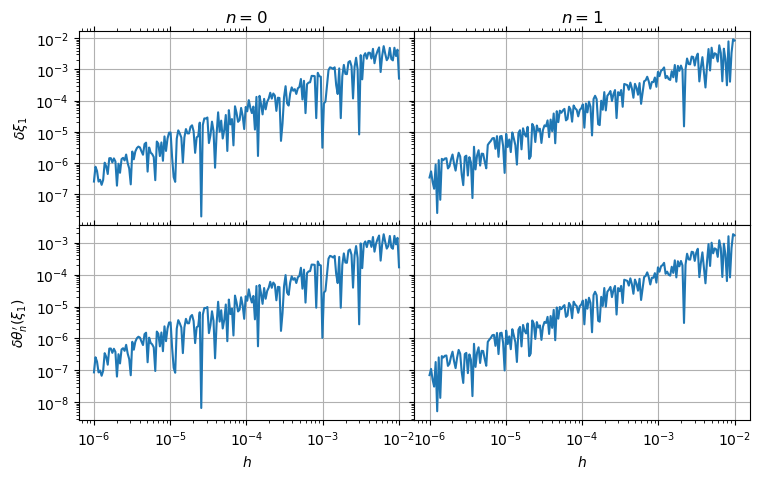

In [3]:
import matplotlib.pyplot as plt

# Load and plot data
npz = np.load('npz/resolution_study.npz')
ns, hs, dxs, dzs = npz['ns'], npz['hs'], npz['dxs'], npz['dzs']
fig, axs = plt.subplots(2, ns.size, sharex=True, sharey='row',
                        figsize=(8.66, 5.06))

for i in range(ns.size):
    axs[0][i].loglog(hs, dxs[i])
    axs[1][i].loglog(hs, dzs[i])

# Format and save figure
for ax in axs.flat:
    ax.grid()
    ax.minorticks_on()
    ax.tick_params(axis='both', which='both', top=True)

axs[0][0].set(title=r'$n=0$', ylabel=r'$\delta\xi_1$')
axs[0][1].set(title=r'$n=1$')
axs[1][0].set(xlabel=r'$h$', ylabel=r'$\delta\theta^\prime_n(\xi_1)$')
axs[1][1].set(xlabel=r'$h$')
plt.subplots_adjust(hspace=0, wspace=0)


## Results

In [4]:
# Compute and save the polytropic parameters ξ₁, θₙ'(ξ₁), and ρ_c/⟨ρ⟩ for a
# range of polytropic indices n.

h = 1e-5                                                 # step size
num = 50                                                 # no. of n samples
xs = np.zeros(num + 1)                                   # to store ξ₁
zs = np.zeros(num + 1)                                   # to store θₙ'(ξ₁)
rhos = np.zeros(num + 1)                                 # to store ρ_c/⟨ρ⟩
n_min, n_max = 0, 4                                      # range of n values
n_step = (n_max - n_min)/num
ns = [n_min]

print('Creating evenly-spaced range of n values...', flush=True)
for i in range(num):
    ns.append(ns[-1] + n_step)

print('  Done.\nComputing and storing parameters for each n...', flush=True)
for i, n in enumerate(ns):
    x = 1e-16                                            # ξ
    y = yfunc(x, n)                                   # θₙ
    z = zfunc(x, n)                                   # θₙ' = dθₙ/dξ = dy/dx

    while y.real > 0:
        x, y, z = rk4(n, x, y, z, h)
    
    xs[i], zs[i], rhos[i] = x, z.real, -x/z.real/3
    sys.stdout.write(f'\r  {(i+1)/len(ns):.0%}')

print("  Done.\nSaving results for plotting in 'fig2.py'...", flush=True)
np.savez_compressed('npz/results', ns=ns, xs=xs, zs=zs, rhos=rhos)

print("  Done.\nGenerating Table 1...", flush=True)
ns = [0, 1.0, 1.5, 2.0, 3.0, 4.0]

print()
print('--------------------------------')
print('Index n\t  ξ₁\t-θₙ′(ξ₁) ρ_c/<ρ>')
print('--------------------------------')

for n in ns:
    x = 1e-16
    y = yfunc(x, n)
    z = zfunc(x, n)

    while y.real > 0:
        x, y, z = rk4(n, x, y, z, h)

    rhoc = -x/z.real/3

    print(f'  {n:.1f}\t{x:.4f}\t{-z.real:.5f}\t{rhoc:.4f}')

print()
print('Finished.', flush=True)


Creating evenly-spaced range of n values...
  Done.
Computing and storing parameters for each n...
  100%  Done.
Saving results for plotting in 'fig2.py'...
  Done.
Generating Table 1...

--------------------------------
Index n	  ξ₁	-θₙ′(ξ₁) ρ_c/<ρ>
--------------------------------
  0.0	2.4495	0.81650	1.0000
  1.0	3.1416	0.31831	3.2899
  1.5	3.6538	0.20330	5.9907
  2.0	4.3529	0.12725	11.4026
  3.0	6.8968	0.04243	54.1825
  4.0	14.9715	0.00802	622.4083

Finished.


### Numerical Representations of Analytic Solutions

In [5]:
import numpy as np

x0ref, y0ref, rhoc0ref = np.sqrt(6), np.sqrt(6)/3, 1
x1ref, y1ref, rhoc1ref = np.pi,      1/np.pi,      np.pi**2/3

print('Table 7.1. (for numerical reference)')
print('------------------------------------')
print('Index n\t  ξ₁\t-θₙ′(ξ₁) ρ_c/<ρ>')
print('------------------------------------')
print(f'   0\t{x0ref:.4f}\t{y0ref:.4f}\t{rhoc0ref:n}')
print(f'  1.0\t{x1ref:.4f}\t{y1ref:.4f}\t{rhoc1ref:.4f}')

Table 7.1. (for numerical reference)
------------------------------------
Index n	  ξ₁	-θₙ′(ξ₁) ρ_c/<ρ>
------------------------------------
   0	2.4495	0.8165	1
  1.0	3.1416	0.3183	3.2899


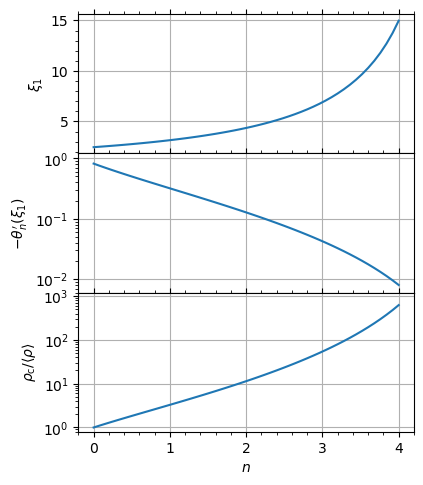

In [6]:
# Plot the output saved by 'results.py'.

# Load and plot data
npz = np.load('npz/results.npz')
ns, xs, zs, rhos = npz['ns'], npz['xs'], npz['zs'], npz['rhos']
fig, axs = plt.subplots(3, sharex=True, figsize=(4.33, 5.42))

axs[0].plot(ns, xs)
axs[1].semilogy(ns, -zs)
axs[2].semilogy(ns, rhos)

# Format and save figure
for ax in axs.flat:
    ax.grid()
    ax.minorticks_on()
    ax.tick_params(axis='both', which='both', top=True)

axs[0].set(ylabel=r'$\xi_1$')
axs[1].set(ylabel=r'$-\theta_n^\prime(\xi_1)$', ylim=(6e-3, 1.2))
axs[2].set(xlabel=r'$n$', ylabel=r'$\rho_\mathrm{c} / \langle\rho\rangle$',
           ylim=(8e-1, 1.2e3))
plt.subplots_adjust(hspace=0)
